# return & FDF & ADF
- 对一阶差分的return做统计分析
- 对close price做分数阶差分
- 对差分结果做ADF，找到满足序列平稳情况下，记忆力最强的序列

### 1. 导入必要的库

In [4]:
# 1. Import dependencies and load Dollar Bars data
from pathlib import Path
from scipy import stats
import numpy as np
import pandas as pd
import numba
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from src.utils.logger import logger

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

project_root = Path.cwd().parent.parent  # two levels above notebooks/data_process/
bars_path = project_root / "data" / "preprocess_data" \
    / "dollar_bars" / "BTCUSDT" / "BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m.csv"

df = pd.read_csv(bars_path)

### 2. return 统计数据

In [5]:
# 2. Compute log returns
col_data = df["timestamp"]

if np.issubdtype(col_data.dtype, np.number):
    ts = col_data.astype("int64")
    # Use number of digits to distinguish ms / us: <=13 digits -> ms, >13 digits -> us
    ts_len = ts.astype("string").str.len()
    ms_mask = ts_len <= 13
    us_mask = ts_len > 13
    logger.info(f"Time column timestamp: {ms_mask.sum()} rows as ms, {us_mask.sum()} rows as us")
    
    dt = pd.Series(index=ts.index, dtype="datetime64[ns]")
    if ms_mask.any():
        dt.loc[ms_mask] = pd.to_datetime(ts[ms_mask], unit="ms", errors="coerce")
    if us_mask.any():
        dt.loc[us_mask] = pd.to_datetime(ts[us_mask], unit="us", errors="coerce")
    df["dt"] = dt

df = df.set_index("dt").sort_index()

# Compute log returns: log(p_t / p_{t-1})
df["log_ret"] = np.log(df["close"]).diff()

# Drop the first NaN
returns = df["log_ret"].dropna()

logger.info("Basic statistics of log returns:")
logger.info(f"\n{returns.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])}")

mean = returns.mean()
std = returns.std()
skew = stats.skew(returns)
kurt = stats.kurtosis(returns, fisher=True)  # Fisher=True -> 0 means normal distribution

logger.info(f"Mean: {mean}")
logger.info(f"Standard deviation: {std}")
logger.info(f"Skewness: {skew}")
logger.info(f"Kurtosis (Fisher): {kurt}")

| INFO     | __main__:<module>:10 - Time column timestamp: 0 rows as ms, 82145 rows as us
| INFO     | __main__:<module>:27 - Basic statistics of log returns:
| INFO     | __main__:<module>:28 - 
count    8.214400e+04
mean    -8.106765e-07
std      1.581600e-03
min     -2.245976e-02
1%      -4.144171e-03
5%      -2.468055e-03
50%     -5.572076e-07
95%      2.502658e-03
99%      4.233636e-03
max      1.577194e-02
Name: log_ret, dtype: float64
| INFO     | __main__:<module>:35 - Mean: -8.10676493705736e-07
| INFO     | __main__:<module>:36 - Standard deviation: 0.0015815999806702166
| INFO     | __main__:<module>:37 - Skewness: 0.03209583437633453
| INFO     | __main__:<module>:38 - Kurtosis (Fisher): 4.404423651115859


### 3. return 时序图 分布直方图 Boxplot图 QQ图 

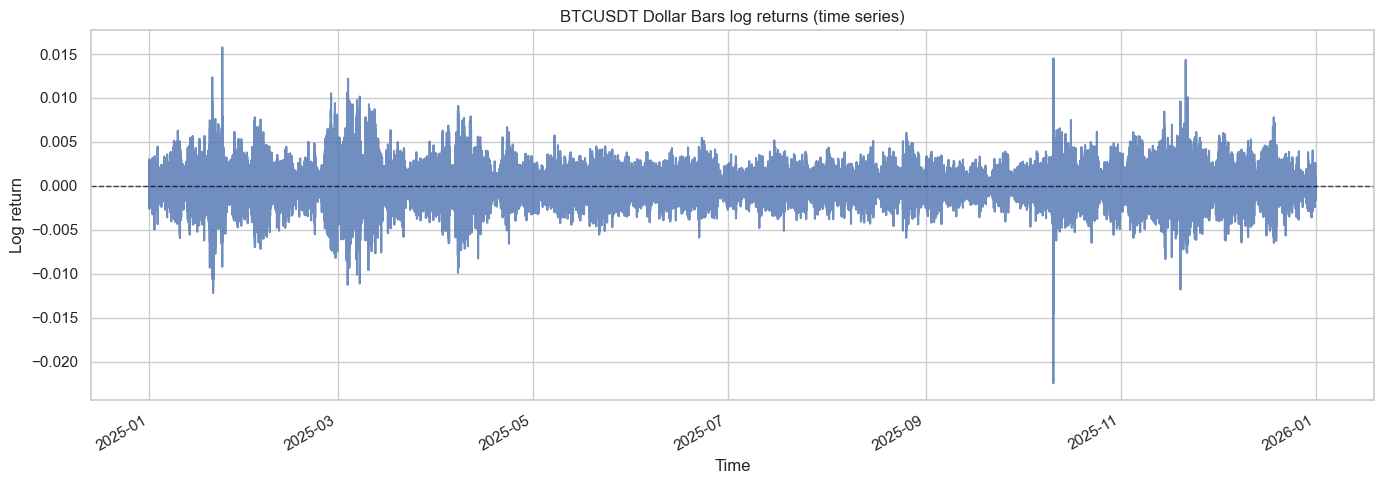

In [6]:
# 3. Time series of log returns
plt.figure(figsize=(14, 5))
returns.plot(alpha=0.8)
plt.title("BTCUSDT Dollar Bars log returns (time series)")
plt.xlabel("Time")
plt.ylabel("Log return")
plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

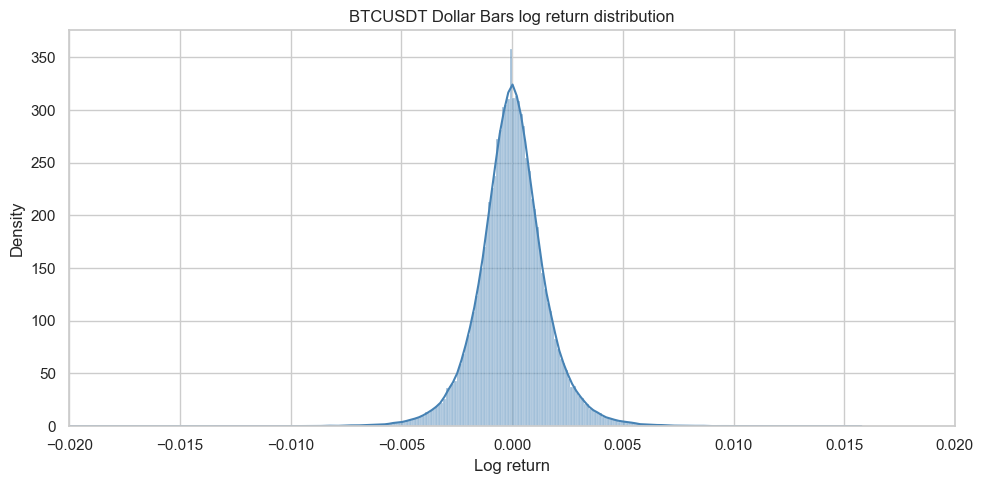

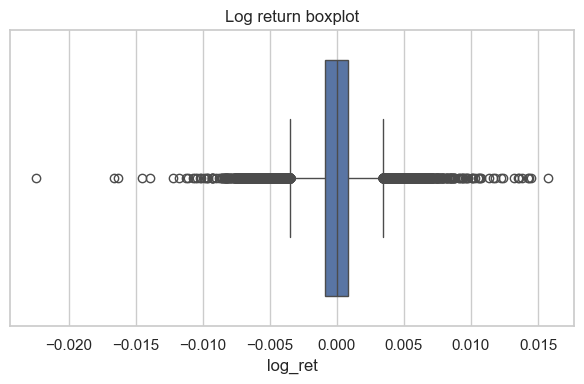

In [7]:
# 4. Distribution of log returns: histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=320, kde=True, stat="density", color="steelblue")
plt.title("BTCUSDT Dollar Bars log return distribution")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.xlim(-0.02, 0.02)
plt.tight_layout()
plt.show()

# 5. Boxplot to inspect tails and skewness
plt.figure(figsize=(6, 4))
sns.boxplot(x=returns, orient="h")
plt.title("Log return boxplot")
plt.tight_layout()
plt.show()

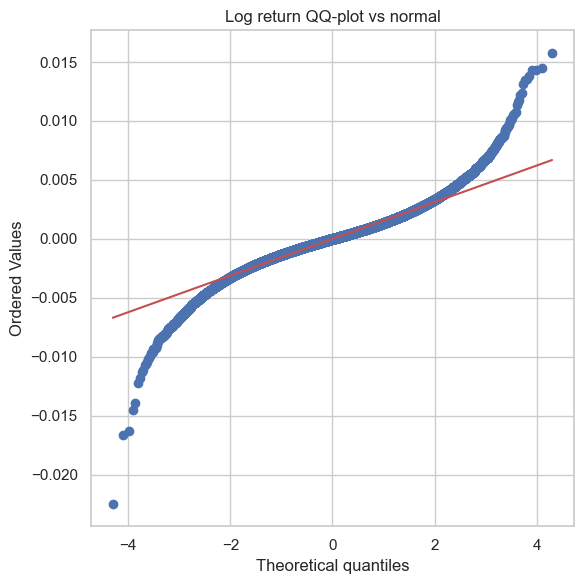

In [8]:
# 6. QQ plot
fig = plt.figure(figsize=(6, 6))
stats.probplot(returns, dist="norm", plot=plt)
plt.title("Log return QQ-plot vs normal")
plt.tight_layout()
plt.show()

### 4. 对return做ADF

In [9]:
# ADF (Augmented Dickey-Fuller) unit root test for return series.
# Goal: check if returns are stationary (reject H0 -> stationary).
def ADF(returns):
    # 1) Prepare the return series: drop NaN/inf and ensure 1D float array.
    #    ADF is sensitive to missing values; we clean explicitly to avoid silent errors.
    ret_series = returns.replace([np.inf, -np.inf], np.nan).dropna()
    ret_values = ret_series.to_numpy(dtype=float)

    # 2) Choose test settings.
    #    - regression: 'c' includes a constant (mean) term only; common for returns.
    #    - autolag: 'AIC' lets the test pick lag length to reduce autocorrelation.
    adf_result = adfuller(ret_values, regression="c", autolag="AIC")

    # 3) Unpack results for readability.
    adf_stat = adf_result[0]
    p_value = adf_result[1]
    used_lag = adf_result[2]
    n_obs = adf_result[3]
    crit_values = adf_result[4]
    ic_best = adf_result[5]

    # 4) Report key outputs in a compact, interpretable format.
    logger.info(f"ADF Statistic: {adf_stat}")
    logger.info(f"p-value: {p_value}")
    logger.info(f"Used lag: {used_lag}")
    logger.info(f"Number of observations: {n_obs}")
    logger.info(f"Best IC (AIC): {ic_best}")
    logger.info(f"Critical values:")
    for level, value in crit_values.items():
        logger.info(f"{level}: {value}")
    
    # 5) Simple decision rule at 5% level (can adjust as needed).
    if p_value < 0.05:
        logger.info("Conclusion: reject H0 (unit root). Returns appear stationary.")
    else:
        logger.info("Conclusion: fail to reject H0. Returns may be non-stationary.")

ADF(returns)

| INFO     | __main__:ADF:23 - ADF Statistic: -290.3178462514174
| INFO     | __main__:ADF:24 - p-value: 0.0
| INFO     | __main__:ADF:25 - Used lag: 0
| INFO     | __main__:ADF:26 - Number of observations: 82143
| INFO     | __main__:ADF:27 - Best IC (AIC): -825746.4786891411
| INFO     | __main__:ADF:28 - Critical values:
| INFO     | __main__:ADF:30 - 1%: -3.430429611219005
| INFO     | __main__:ADF:30 - 5%: -2.8615751868272428
| INFO     | __main__:ADF:30 - 10%: -2.566788728731559
| INFO     | __main__:ADF:34 - Conclusion: reject H0 (unit root). Returns appear stationary.


### 5. 计算FDF

In [ ]:
# ==========================================
# 1. 数据准备 (Data Preparation)
# ==========================================
# 对数价格是量化标准做法，解决了 BTC 价格跨度大的异方差问题
# 清洗：ADF 对 NaN/Inf 极其敏感，必须剔除
logger.info("Preparing data: Calculating log-close and cleaning NaNs...")
log_close = np.log(df["close"]).replace([np.inf, -np.inf], np.nan).dropna()


# ==========================================
# 2. 核心算法库 (Core Algorithms)
# ==========================================

def get_weights_ffd(d, thresh=1e-5, max_width=20000):
    """
    计算分数阶差分的权重 (Fixed-Width Window)。
    
    改进点：
    - max_width 默认值提升至 20,000。
    - 只有当 d 极小导致窗口即使到了 2万 还没衰减到 thresh 时，才强制截断。
    - 保证了绝大多数情况下由 thresh (精度) 决定窗口宽度，而非人为限制。
    """
    weights = [1.0]
    k = 1
    while True:
        # 递推公式
        w_k = -weights[-1] * (d - k + 1) / k
        
        # 1. 精度达标，停止 (主要停止条件)
        if abs(w_k) < thresh:
            break
            
        # 2. 安全截断，防止死循环或内存爆炸 (保险丝)
        if len(weights) >= max_width:
            break
            
        weights.append(w_k)
        k += 1
        
    return np.array(weights[::-1], dtype=np.float64)

@numba.jit(nopython=True, parallel=True, cache=True)
def frac_diff_ffd_numba(values, weights):
    """
    Numba 加速的差分计算引擎。
    """
    width = len(weights)
    n = len(values)
    out = np.full(n, np.nan, dtype=np.float64)
    
    # 使用 prange 进行并行循环 (并行计算每一个时间点的差分值)
    for i in numba.prange(width - 1, n):
        window = values[i - width + 1 : i + 1]
        
        # 手动检查 NaN (Numba 中比 np.isnan(window).any() 更快且兼容性更好)
        has_nan = False
        for j in range(width):
            if np.isnan(window[j]):
                has_nan = True
                break
        
        if not has_nan:
            out[i] = np.dot(weights, window)
            
    return out

def frac_diff_ffd(series, d, thresh=1e-5):
    """FFD 主函数：整合权重计算与 Numba 加速"""
    # 这里的 max_width 设为 20000，足以应对 d=0.1 左右的情况
    weights = get_weights_ffd(d, thresh=thresh, max_width=20000)
    
    # 如果窗口比数据还长，无法计算
    if len(weights) > len(series):
        return pd.Series(np.nan, index=series.index)
        
    values = series.to_numpy(dtype=np.float64)
    out_values = frac_diff_ffd_numba(values, weights)
    return pd.Series(out_values, index=series.index)

def adf_summary(series, min_obs=100, maxlag=48):
    """
    ADF 检验辅助函数。
    - maxlag=48: 大概检测4个小时长度的相关性
    """
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(clean) < min_obs:
        return {"p_value": np.nan, "adf_stat": np.nan, "n_obs": len(clean), "corr": np.nan}
    
    # 执行 ADF 检验
    adf = adfuller(clean.to_numpy(dtype=float), regression="c", autolag="AIC", maxlag=maxlag)
    
    return {
        "p_value": adf[1], 
        "adf_stat": adf[0], 
        "n_obs": adf[3],
        "used_lag": adf[2]
    }


# ==========================================
# 3. 执行网格搜索 (Grid Search)
# ==========================================
d_grid = np.round(np.arange(0.0, 1.01, 0.01), 2)
results = []

logger.info(f"Starting FFD+ADF scan (Parallelized): {len(d_grid)} times.")

# 使用 tqdm 显示进度条
for d in tqdm(d_grid, desc="ADF Scan", unit="times"):
    # 1. 计算差分
    ffd_series = frac_diff_ffd(log_close, d, thresh=1e-5)
    
    # 2. 计算 ADF 指标
    stats = adf_summary(ffd_series, min_obs=100, maxlag=12)
    
    # 3. 计算相关性 (额外增加的指标)
    # 这能让你看到 d 增加时，与原始价格的相关性是如何下降的
    if stats["n_obs"] > 100:
        # 注意：这里要对齐索引计算相关性
        corr = ffd_series.corr(log_close)
    else:
        corr = np.nan
        
    results.append({"d": d, "corr": corr, **stats})
    
    if stats["p_value"] <0.05:
        break

# 转换结果为 DataFrame
results_df = pd.DataFrame(results)

# ==========================================
# 4. 结果展示与决策 (Decision)
# ==========================================
# 筛选通过检验的结果 (p-value < 0.05)
valid = results_df[results_df["p_value"] < 0.05]

if not valid.empty:
    # 找到最小的 d
    best_row = valid.iloc[0]
    best_d = float(best_row["d"])
    
    # 理论最优是 best_d，但为了稳健，建议实盘加 0.05
    robust_d = round(best_d + 0.05, 2)
    
    logger.info(f"{'='*60}")
    logger.info(f"MATHEMATICAL OPTIMUM d: {best_d} (p-value: {best_row['p_value']:.4f})")
    logger.info(f"Correlation with Price: {best_row['corr']:.4f}")
    logger.info(f"Valid Observations: {int(best_row['n_obs'])}")
    logger.info(f"{'-'*60}")
    logger.info(f"RECOMMENDED d (for feature eng): {robust_d}")
    logger.info(f"(Adding small buffer to ensure stationarity in future data)")
    logger.info(f"{'='*60}")

    # ==========================================
    # 5. 生成最终特征 (Final Feature Generation)
    # ==========================================
    # 这一步生成你接下来要用的列
    logger.info(f"Generating final feature column 'ffd_log_close' with d={robust_d}...")
    df['ffd_log_close'] = frac_diff_ffd(log_close, d=robust_d, thresh=1e-5)
    
    # 检查一下最终数据有多少非空
    valid_count = df['ffd_log_close'].count()
    logger.info(f"Feature created. Valid rows: {valid_count}/{len(df)}")
    
else:
    logger.error("No d value found that makes the series stationary! Check data quality or increase d range.")

logger.info(f"\nDetailed ADF results for best FFD series (d={best_d}):")

| INFO     | __main__:<module>:6 - Preparing data: Calculating log-close and cleaning NaNs...
| INFO     | __main__:<module>:106 - Starting FFD+ADF scan (Parallelized): 101 d values.


ADF Scan:   9%|▉         | 9/101 [00:03<00:37,  2.45times/s]

| INFO     | __main__:<module>:146 - ============================================================
| INFO     | __main__:<module>:147 - MATHEMATICAL OPTIMUM d: 0.09 (p-value: 0.0469)
| INFO     | __main__:<module>:148 - Correlation with Price: 0.9950
| INFO     | __main__:<module>:149 - Valid Observations: 78112
| INFO     | __main__:<module>:150 - ------------------------------------------------------------
| INFO     | __main__:<module>:151 - RECOMMENDED d (for feature eng): 0.14
| INFO     | __main__:<module>:152 - (Adding small buffer to ensure stationarity in future data)
| INFO     | __main__:<module>:153 - ============================================================
| INFO     | __main__:<module>:159 - Generating final feature column 'ffd_log_close' with d=0.14...
| INFO     | __main__:<module>:164 - Feature created. Valid rows: 78168/82145
| INFO     | __main__:<module>:169 - 
Detailed ADF results for best FFD series (d=0.09):


In [29]:
ffd_series = frac_diff_ffd(log_close, 0.15, thresh=1e-5)

stats = adf_summary(ffd_series, min_obs=100, maxlag=216) # 过去一天相关性

logger.info(f"p_value: {stats['p_value']}")
logger.info(f"adf_stat: {stats['adf_stat']}")
logger.info(f"n_obs: {stats['n_obs']}")
logger.info(f"used_lag: {stats['used_lag']}")

| INFO     | __main__:<module>:5 - p_value: 0.04204214678883629
| INFO     | __main__:<module>:6 - adf_stat: -2.92932943022772
| INFO     | __main__:<module>:7 - n_obs: 78108
| INFO     | __main__:<module>:8 - used_lag: 136
